In [1]:
%matplotlib widget
%cd ..

/home/antimateria/Documents/github/ConcursoModelizacion2023


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from gradient_descent import Environment, Agent, ConstrainedLoss, ConstrainedLoss_v2, CostLoss, DistanceLoss, optimize
from utils import plot_location

from mpl_toolkits.mplot3d.art3d import Line3DCollection

from heuristicas import estrellato

### Apartado A

In [3]:
K=35
dt = 1.
g = 0.1
m = 10.
F_max = 11.
p_0 = np.array([50., 50., 100.])
v_0 = np.array([-10., 0., -10.])
alpha = 0.5
gamma = 1.

In [4]:
def cost(K, env):
    agent = Agent(K)
    optim = torch.optim.RMSprop(agent.parameters(), lr=1e-1)
    loss = ConstrainedLoss(dt, gamma, F_max, alpha)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.993)
    optimize(env, agent, loss, optim, scheduler, iters=200, verbose=False)
    f = agent()
    p, v = env(agent())
    return loss(f, p, v)

In [5]:
#hacemos busqueda ternaria para encontrar el K optimo
def ternary_search(f, a, b):
    while b-a > 2:
        print(a, b)
        c1 = (2*a+b)//3
        c2 = (a+2*b)//3
        if f(c1) < f(c2):
            b = c2
        else:
            a = c1
    if(f(a) < f(b-1)):
        return a
    else:
        return b-1

env = Environment(dt, gamma, g, m, p_0, v_0)

#heuristicas
a = estrellato(env, F_max)
b = 10*a

K_opt = ternary_search(lambda K: cost(K, env), a, b)
print(K_opt)

10 100
10 70
10 50
10 36
18 36
18 30
22 30
24 30
24 28
25


In [6]:
agent = Agent(K_opt)
optim = torch.optim.RMSprop(agent.parameters(), lr=1e-1)
loss = ConstrainedLoss(dt, gamma, F_max, alpha)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.993)
optimize(env, agent, loss, optim, scheduler, iters=200)

79331.75 [0.0993]
204.34315490722656 [0.04918969140983614]


In [7]:
f = agent()
p, v = env(agent())
print("coste =",loss(f, p, v))

coste = tensor(192.0233, grad_fn=<AddBackward0>)


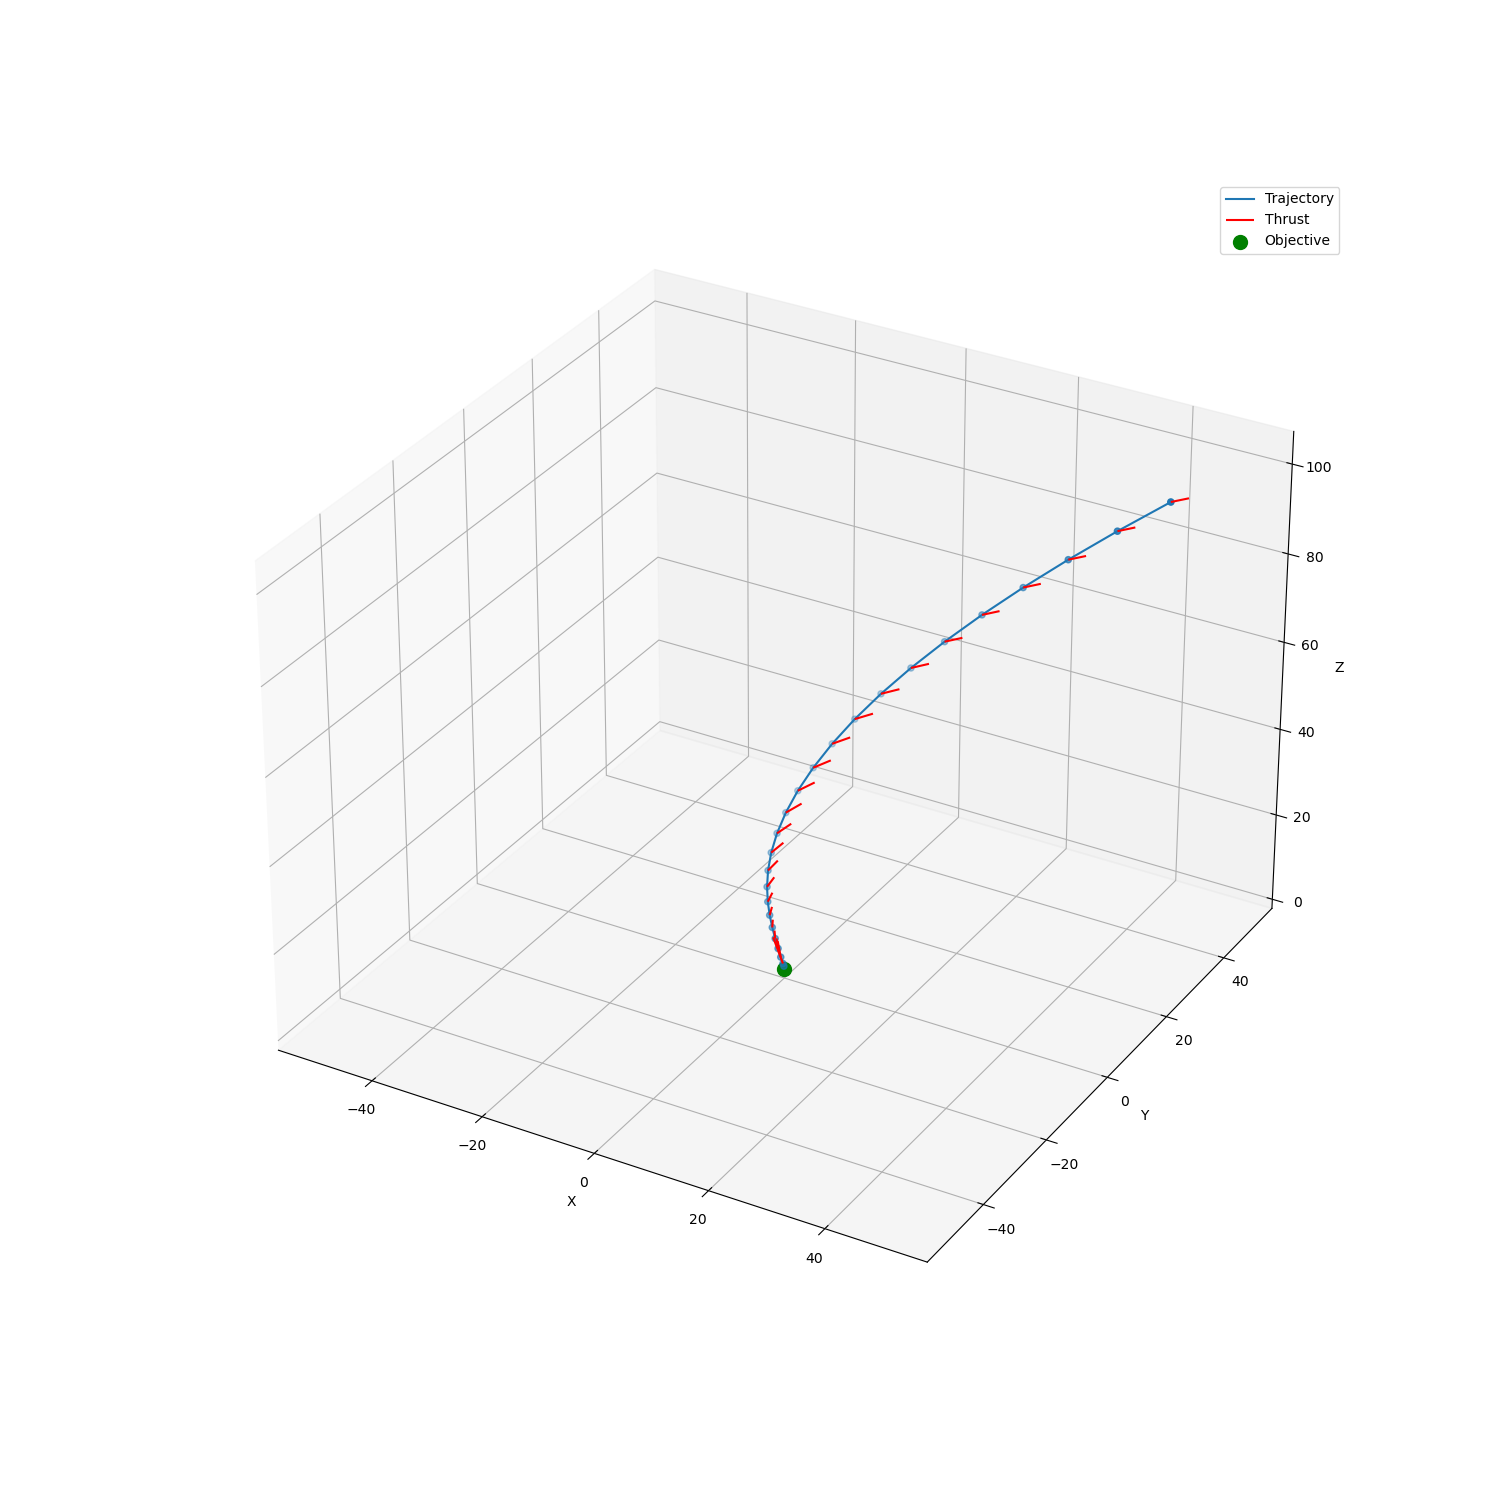

In [8]:
plot_location(f, p, v)

### Apartado B

In [9]:
dt = 1.
g = 0.1
m = 10.
F_max = 11.
p_0 = np.array([50., 50., 100.])
v_0 = np.array([-10., 0., -10.])
alpha = 0.5
gamma = 1.
K_prev = K_opt # K del apartado anterior

In [10]:
def check_factibility(K, env):
    agent = Agent(K)

    loss = ConstrainedLoss_v2(dt, gamma, F_max, alpha)
    optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.993)

    optimize(env, agent, loss, optim, scheduler, iters=2000, verbose=False)

    d_loss = DistanceLoss()

    f = agent()
    p, v = env(f)
    d1, d2 = d_loss(f, p, v)
    d1, d2 = d1.item(), d2.item()

    factible = False
    if d1<1. and d2<1.:
        factible = True

    print(K, d1, d2, factible)

    return factible

In [11]:
env = Environment(dt, gamma, g, m, p_0, v_0)

K_min = estrellato(env, F_max)
K_max = K_prev # del apartado anterior
b_factible = True

print(K_min, K_max)

#ahora hacemos una busqueda binaria
while K_max-K_min>1:
    K = (K_max+K_min)//2
    print(K)
    b_factible = check_factibility(K,env)
    if b_factible:
        K_max = K
    else:
        K_min = K

K = K_max
print("K =",K)

10 25
17
17 4.572434902191162 2.1749305725097656 False
21
21 5.783724191132933e-05 4.9056798161473125e-06 True
19
19 2.546011637605261e-05 0.5441915988922119 True
18
18 0.7088112831115723 1.6518113613128662 False
K = 19


In [12]:
def optimize2(env, agent, loss, loss2, optim, scheduler=None, iters=10000, verbose=True):
    losses_1, losses_2 = [], []
    params = []
    
    for i in range(iters):
        f = agent()
        p, v = env(f)
        l = loss(f, p, v)

        optim.zero_grad()
        l.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(agent.parameters(), 10.)
        optim.step()

        if scheduler is not None:
            scheduler.step()

        if verbose and i%10==0:
            l1 = l.item()
            losses_1 += [l1]
            losses_2 += [loss2(f, p, v).item()]
            params += [f.detach().clone().numpy()]

            print(l1, scheduler.get_last_lr())
            
    return losses_1, losses_2, params

In [13]:
agent = Agent(K)
env = Environment(dt, gamma, g, m, p_0, v_0)

loss = ConstrainedLoss_v2(dt, gamma, F_max, alpha)
loss2 = CostLoss(dt, gamma)
optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.995)

losses_1, losses_2, params = optimize2(env, agent, loss, loss2, optim, scheduler, iters=2000, verbose=True)

35400.55859375 [0.995]
931.9384765625 [0.946354579813443]
1269.0498046875 [0.9000874278732445]
716.090087890625 [0.8560822709551227]
1520.9691162109375 [0.8142285204175609]
2798.97900390625 [0.7744209942832988]
251.4712371826172 [0.736559652908221]
245.90200805664062 [0.7005493475733617]
454.46771240234375 [0.6662995813682115]
391.208251953125 [0.6337242817644086]
158.14952087402344 [0.6027415843082742]
356.45318603515625 [0.5732736268885887]
220.33184814453125 [0.5452463540625918]
247.05422973632812 [0.5185893309484582]
649.678955078125 [0.4932355662165453]
182.89895629882812 [0.46912134373457726]
851.4442749023438 [0.446186062443672]
1035.5260009765625 [0.42437208406280985]
178.99954223632812 [0.4036245882390106]
108.21705627441406 [0.38389143477919885]
74.83358764648438 [0.36512303261753626]
75.48143005371094 [0.3472722151889232]
99.14491271972656 [0.3302941218954743]
110.32957458496094 [0.3141460853680822]
125.42608642578125 [0.2987875242397482]
426.3740234375 [0.28417984116121187]

In [14]:
f = agent()
p, v = env(f)
d_loss = DistanceLoss()
c_loss = CostLoss(dt, gamma)

In [15]:
print(loss(f, p, v))
print(d_loss(f, p, v))
print(c_loss(f, p, v))

tensor(10.8064, grad_fn=<AddBackward0>)
(tensor(0.0014, grad_fn=<LinalgVectorNormBackward0>), tensor(0.5398, grad_fn=<LinalgVectorNormBackward0>))
tensor(197.9985, grad_fn=<MulBackward0>)


In [16]:
f = agent()
p, v = env(f)

d1, d2 = d_loss(f, p, v)
d1, d2 = d1.item(), d2.item()

factible = False
if d1<1. and d2<1.:
    factible = True

print(K, d1, d2, factible)

19 0.0013544601388275623 0.5397698283195496 True


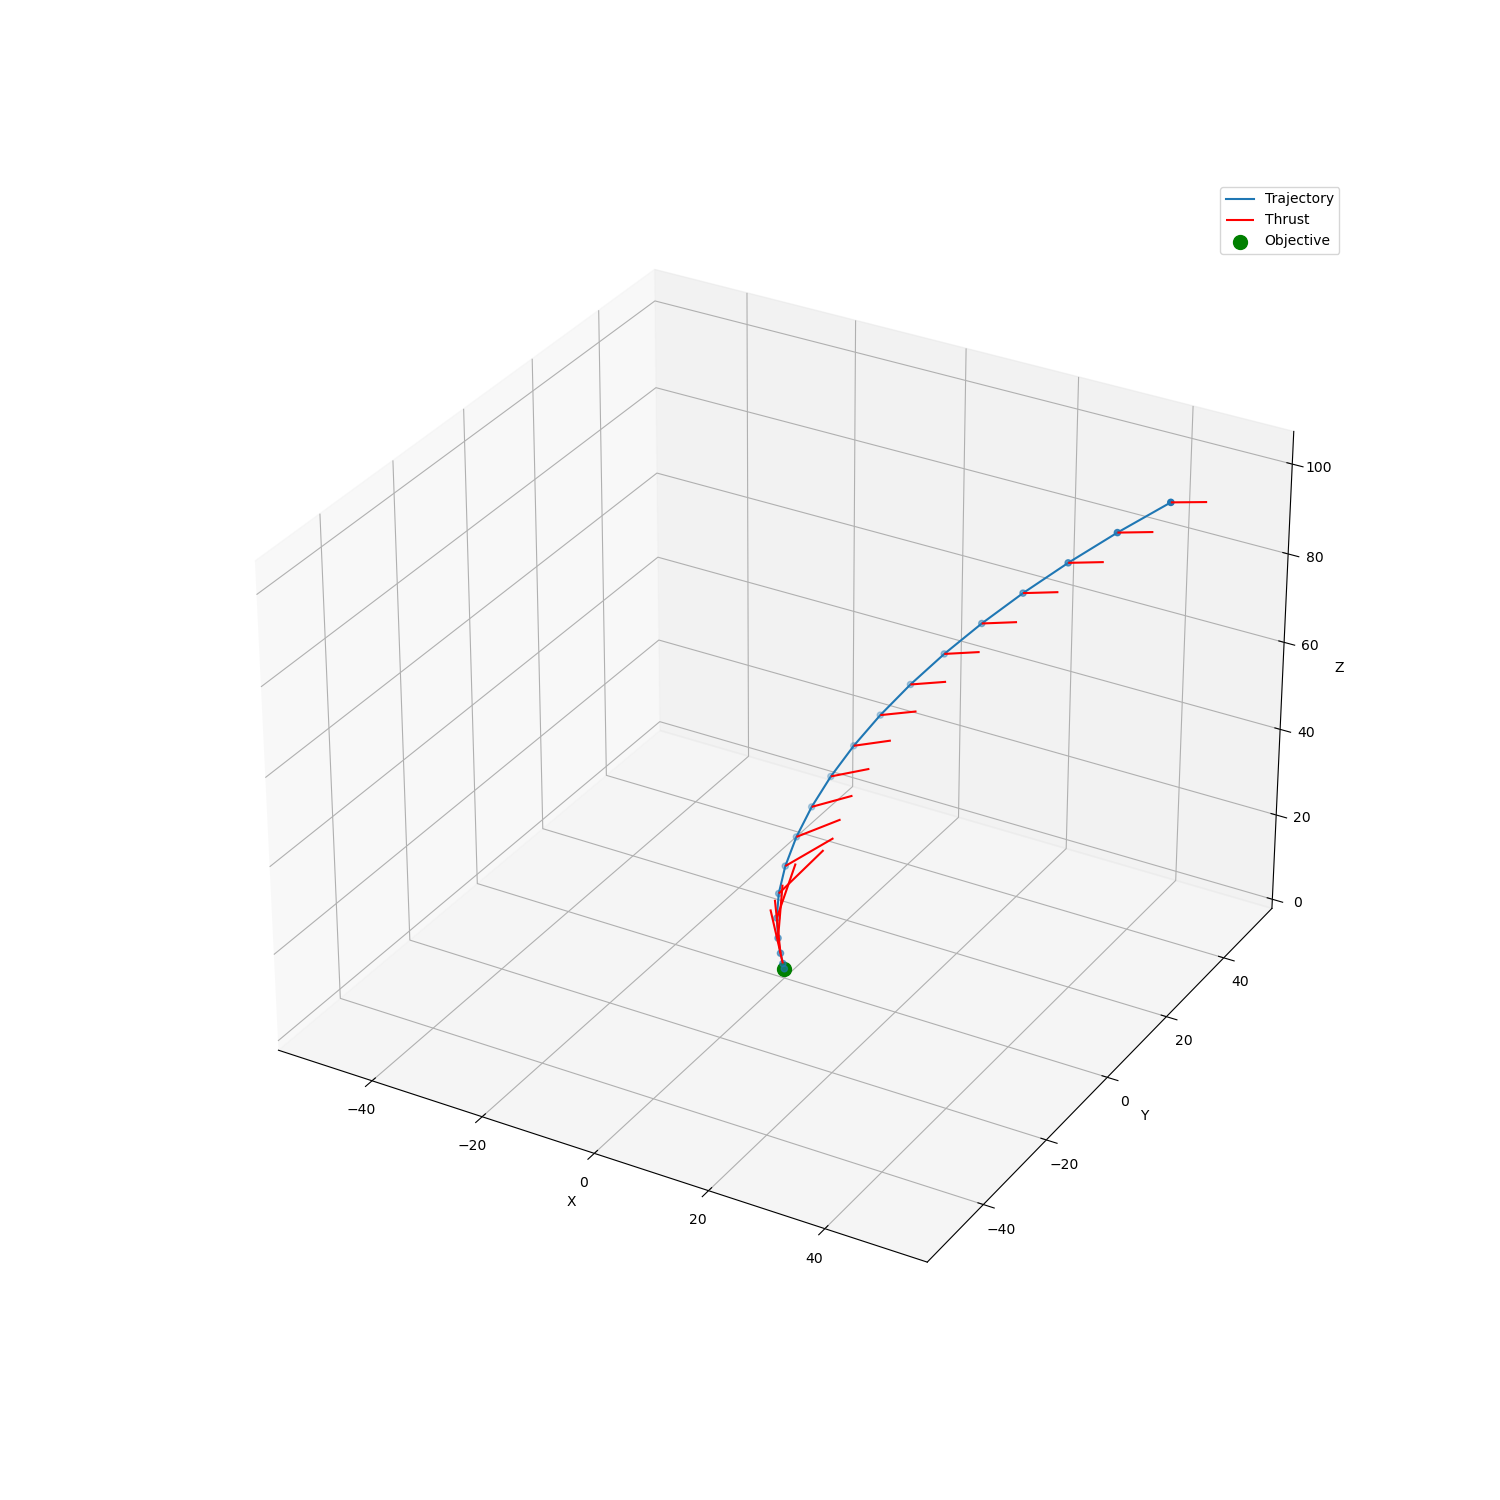

In [17]:
plot_location(f, p, v, lambd=1.0)

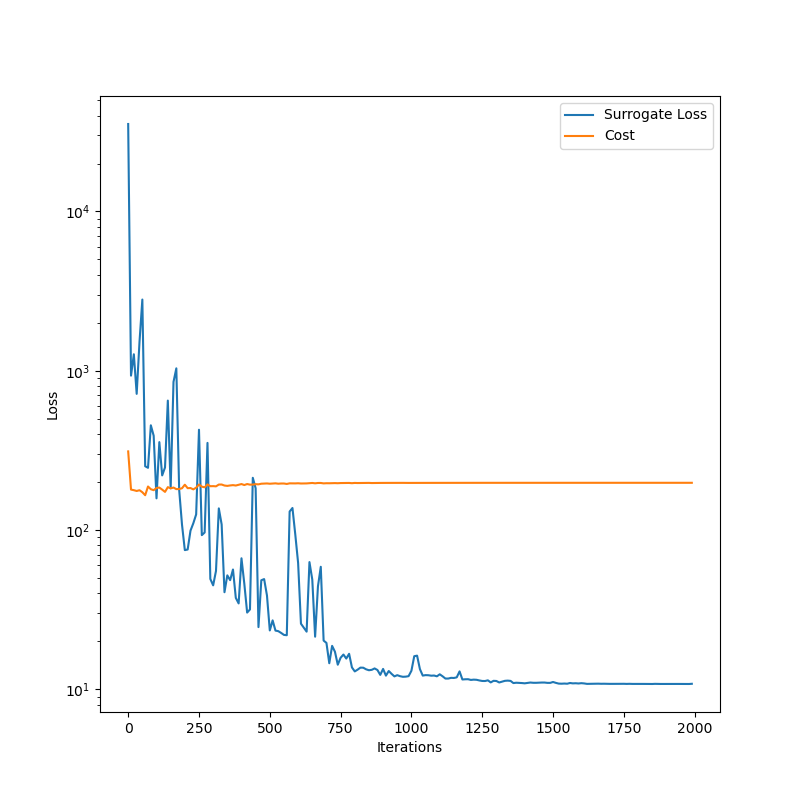

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0,10*len(losses_1),10), losses_1, label='Surrogate Loss')
ax.plot(np.arange(0,10*len(losses_1),10), losses_2, label='Cost')
#ax.set_title('Loss')
ax.set_yscale('log')

ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
ax.legend()
plt.savefig("images/loss_v5.pdf", format="pdf", bbox_inches="tight")
plt.show()  